In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import random
import shutil
from pathlib import Path
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Subset

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input/'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
elements = os.listdir('/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums')
print(elements)

['unripe', 'cracked', 'rotten', 'spotted', 'bruised', 'unaffected']


# 1) Chargement des données

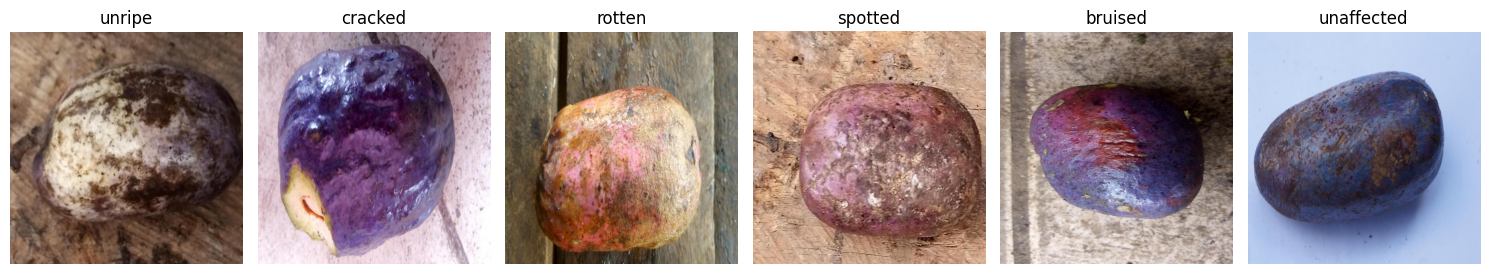

In [3]:
#repertoire racine
path = '/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/'

# Chemin du dossier contenant les sous-dossiers
dossier_images = os.path.join(path, 'african_plums')

# Obtenir les sous-dossiers
classes = [os.path.join(dossier_images, nom) for nom in os.listdir(dossier_images) if os.path.isdir(os.path.join(dossier_images, nom))]

# Créer une figure avec 1 ligne et 6 colonnes
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

# Afficher une image de chaque dossier
for ax, dossier in zip(axes, classes[:6]):  # Limiter à 6 dossiers
    # Charger la première image du dossier
    images = os.listdir(dossier)
    if images:
        image_path = os.path.join(dossier, images[55])  # Prendre la première image
        img = Image.open(image_path)
        ax.imshow(img)
        ax.axis('off')  # Masquer les axes
        ax.set_title(os.path.basename(dossier))  # Titre avec le nom du dossier

# Afficher la figure
plt.tight_layout()
plt.show()

In [4]:
# Chemin du dossier contenant le fichier CSV
nom_fichier = 'organized_plums_data_new.csv'

# Construire le chemin complet du fichier
chemin_fichier = os.path.join(path, nom_fichier)

# Charger le fichier CSV dans un DataFrame
df = pd.read_csv(chemin_fichier)

df.sample(10)

,Image ID,Label,Defect Type
4385,unripe_plum_705,unripe,unripe
3882,unripe_plum_202,unripe,unripe
3445,unaffected_plum_1486,good,unaffected
2010,unaffected_plum_51,good,unaffected
3276,unaffected_plum_1317,good,unaffected
1587,spotted_plum_387,defective,spotted
4150,unripe_plum_470,unripe,unripe
3448,unaffected_plum_1489,good,unaffected
4285,unripe_plum_605,unripe,unripe
3558,unaffected_plum_1599,good,unaffected


In [5]:
df.shape

(4507, 3)

In [6]:
df.columns = ['Image_Id', 'Label', 'class']
df.sample(10)

,Image_Id,Label,class
4029,unripe_plum_349,unripe,unripe
4435,unripe_plum_755,unripe,unripe
1265,spotted_plum_65,defective,spotted
448,cracked_plum_130,defective,cracked
3417,unaffected_plum_1458,good,unaffected
3029,unaffected_plum_1070,good,unaffected
1580,spotted_plum_380,defective,spotted
2508,unaffected_plum_549,good,unaffected
1975,unaffected_plum_16,good,unaffected
3907,unripe_plum_227,unripe,unripe


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4507 entries, 0 to 4506
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_Id  4507 non-null   object
 1   Label     4507 non-null   object
 2   class     4507 non-null   object
dtypes: object(3)
memory usage: 105.8+ KB


In [8]:
df.isna().sum(axis=0)

Image_Id    0
Label       0
class       0
dtype: int64

In [9]:
df.duplicated().sum()
print(f"Nombre total de valeurs dupliquées : {df.duplicated().sum()}")

Nombre total de valeurs dupliquées : 0


In [10]:
print("Nombre total d'image pour chaque type de classe :")
df.groupby('class').size()

Nombre total d'image pour chaque type de classe :


class
bruised        319
cracked        162
rotten         720
spotted        759
unaffected    1721
unripe         826
dtype: int64

In [11]:
df.groupby('Label')['class'].agg(lambda x: list(set(x))).reset_index()

,Label,class
0,defective,"[cracked, rotten, spotted, bruised]"
1,good,[unaffected]
2,unripe,[unripe]


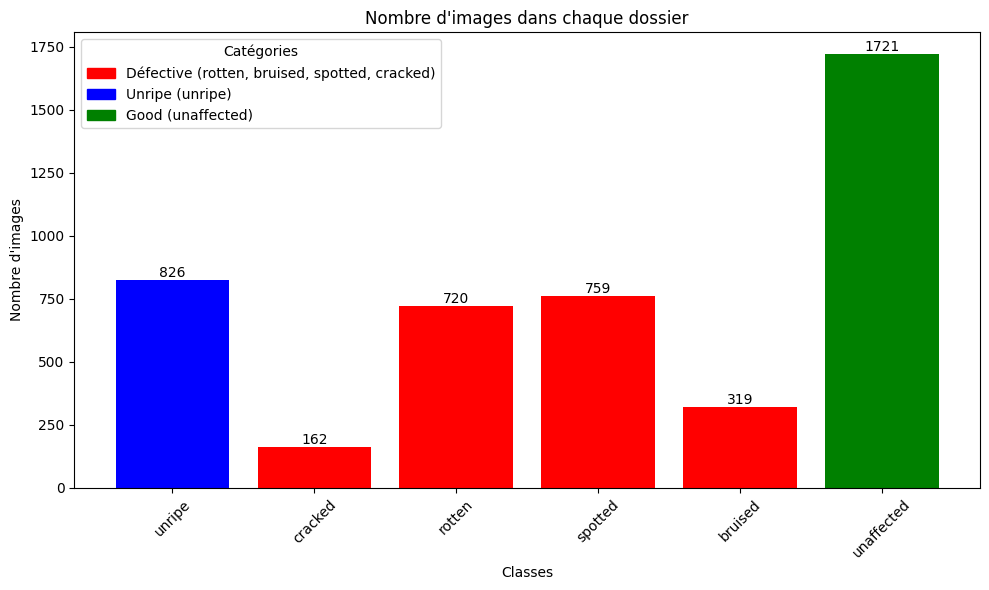

In [12]:
# Initialiser les listes pour les noms de dossiers et le nombre d'images
noms_dossiers = []
nombre_images = []

# Compter le nombre d'images dans chaque sous-dossier
for nom in os.listdir(dossier_images):
    chemin_dossier = os.path.join(dossier_images, nom)
    if os.path.isdir(chemin_dossier):
        images = [f for f in os.listdir(chemin_dossier) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        noms_dossiers.append(nom)
        nombre_images.append(len(images))

# Déterminer les couleurs des barres
couleurs = ['red' if nom in ['rotten', 'bruised', 'spotted', 'cracked'] else 'blue' if nom == 'unripe' else 'green' for nom in noms_dossiers]

# Créer l'histogramme
plt.figure(figsize=(10, 6))
ax = plt.bar(noms_dossiers, nombre_images, color=couleurs)

# Ajouter des étiquettes sur les barres
plt.bar_label(ax)

# Configurer les axes et le titre
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images dans chaque dossier')
plt.xticks(rotation=45)
plt.tight_layout()  # Ajuster l'espacement
# Ajouter la légende
plt.legend(
    handles=[
        plt.Rectangle((0, 0), 1, 1, color='red', label='Défective (rotten, bruised, spotted, cracked)'),
        plt.Rectangle((0, 0), 1, 1, color='blue', label='Unripe (unripe)'),
        plt.Rectangle((0, 0), 1, 1, color='green', label='Good (unaffected)')
    ],
    title='Catégories'
)
plt.show()

# 2) Prétraitement des images

In [24]:
def compter_elements(chemin, display_element=False):
    try:
        # Lister les éléments dans le répertoire
        elements = os.listdir(chemin)
        # Compter le nombre d'éléments
        nombre_elements = len(elements)
        
        if display_element:
            print(f"Éléments du répertoire : {elements}")
        
        print(f"Nombre d'éléments : {nombre_elements}")
        
    except FileNotFoundError:
        return "Le chemin spécifié n'existe pas."
    except PermissionError:
        return "Accès refusé au chemin spécifié."

In [25]:
compter_elements(path, True)

Éléments du répertoire : ['README.md', 'organized_plums_data_new.csv', 'african_plums']
Nombre d'éléments : 3


In [26]:
path

'/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/'

## 2.1) Configuration des chemins

In [27]:
# Définir les chemins
work_path = os.getcwd()
path_data = os.path.join(path, 'african_plums')  # Dossier source
data_use = os.path.join(work_path, '/data')            # Dossier cible
folder_model_1 = os.path.join(work_path, '/model_1')
folder_model_2 = os.path.join(work_path, '/model_2')
train_val_temp_1 = os.path.join(folder_model_1, 'train_val_temp_1')
train_val_temp_2 = os.path.join(folder_model_2, 'train_val_temp_2')
test_1 = os.path.join(folder_model_1, 'test_1')
test_2 = os.path.join(folder_model_2, 'test_2')

In [28]:
# Fonction pour créer un dossier (et le recréer s'il existe)
def create_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"🗑️ Dossier existant supprimé : {path}")
    os.makedirs(path)
    print(f"📁 Nouveau dossier créé : {path}")

# Création des dossiers nécessaires
print("🔧 Création des dossiers requis...")
create_folder(data_use)
create_folder(folder_model_1)
create_folder(folder_model_2)
create_folder(train_val_temp_1)
create_folder(train_val_temp_2)
create_folder(test_1)
create_folder(test_2)

# Fonction pour copier les fichiers/dossiers avec barre de progression
def copy_with_progress(src, dst):
    if not os.path.exists(dst):
        os.makedirs(dst)
        
    items = os.listdir(src)
    print(f"\n📦 Copie de {len(items)} éléments de '{src}' vers '{dst}'...\n")
    
    for item in tqdm(items, desc="📤 Copie en cours", unit="élément"):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d)
        else:
            shutil.copy2(s, d)

# Lancer la copie
copy_with_progress(path_data, data_use)

print("\n✅ Opération terminée avec succès ! Tous les fichiers ont été copiés 🎉")

🔧 Création des dossiers requis...
🗑️ Dossier existant supprimé : /data
📁 Nouveau dossier créé : /data
🗑️ Dossier existant supprimé : /model_1
📁 Nouveau dossier créé : /model_1
🗑️ Dossier existant supprimé : /model_2
📁 Nouveau dossier créé : /model_2
📁 Nouveau dossier créé : /model_1/train_val_temp_1
📁 Nouveau dossier créé : /model_2/train_val_temp_2
📁 Nouveau dossier créé : /model_1/test_1
📁 Nouveau dossier créé : /model_2/test_2

📦 Copie de 6 éléments de '/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums' vers '/data'...



📤 Copie en cours: 100%|██████████| 6/6 [00:08<00:00,  1.35s/élément]


✅ Opération terminée avec succès ! Tous les fichiers ont été copiés 🎉


In [29]:
compter_elements(work_path, True)
compter_elements(data_use, True)
compter_elements(folder_model_1, True)
compter_elements(folder_model_2, True)

Éléments du répertoire : ['data', 'model_1', 'african_plums_split_1', 'model_2', '.virtual_documents']
Nombre d'éléments : 5
Éléments du répertoire : ['spotted', 'cracked', 'bruised', 'unaffected', 'unripe', 'rotten']
Nombre d'éléments : 6
Éléments du répertoire : ['train_val_temp_1', 'test_1']
Nombre d'éléments : 2
Éléments du répertoire : ['train_val_temp_2', 'test_2']
Nombre d'éléments : 2


#### Séparation des images en test et trai_val

In [30]:
# Classes à traiter
classes_model_1 = ['spotted', 'cracked', 'bruised', 'unaffected', 'unripe', 'rotten']
classes_model_2 = ['spotted', 'cracked', 'bruised', 'rotten']

def split_images(source_root, target_train, target_test, classes, ratio=0.1):
    for class_name in tqdm(classes, desc="🔍 Traitement des classes", unit="classe"):
        source_class_dir = os.path.join(source_root, class_name)
        images = os.listdir(source_class_dir)
        random.shuffle(images)

        test_count = int(len(images) * ratio)
        test_images = images[:test_count]
        train_images = images[test_count:]

        # Dossiers cibles
        class_train_dir = os.path.join(target_train, class_name)
        class_test_dir = os.path.join(target_test, class_name)

        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_test_dir, exist_ok=True)

        # Copier les images de test
        for img in test_images:
            src = os.path.join(source_class_dir, img)
            dst = os.path.join(class_test_dir, img)
            shutil.copy2(src, dst)

        # Copier les images de train_val
        for img in train_images:
            src = os.path.join(source_class_dir, img)
            dst = os.path.join(class_train_dir, img)
            shutil.copy2(src, dst)

        print(f"📂 Classe '{class_name}': {len(train_images)} entraînement/val | {len(test_images)} test")

# Séparation pour le model_1
print("\n🚀 Séparation pour le model_1")
split_images(data_use, train_val_temp_1, test_1, classes_model_1)

# Séparation pour le model_2
print("\n🚀 Séparation pour le model_2")
split_images(data_use, train_val_temp_2, test_2, classes_model_2)

print("\n✅ Séparation terminée avec succès pour les deux modèles ! 🎉")


🚀 Séparation pour le model_1


🔍 Traitement des classes:  17%|█▋        | 1/6 [00:00<00:00,  5.04classe/s]

📂 Classe 'spotted': 684 entraînement/val | 75 test


🔍 Traitement des classes:  50%|█████     | 3/6 [00:00<00:00, 10.59classe/s]

📂 Classe 'cracked': 146 entraînement/val | 16 test
📂 Classe 'bruised': 288 entraînement/val | 31 test


🔍 Traitement des classes:  83%|████████▎ | 5/6 [00:00<00:00,  4.83classe/s]

📂 Classe 'unaffected': 1549 entraînement/val | 172 test
📂 Classe 'unripe': 744 entraînement/val | 82 test


🔍 Traitement des classes: 100%|██████████| 6/6 [00:01<00:00,  5.43classe/s]


📂 Classe 'rotten': 648 entraînement/val | 72 test

🚀 Séparation pour le model_2


🔍 Traitement des classes:  25%|██▌       | 1/4 [00:00<00:00,  5.77classe/s]

📂 Classe 'spotted': 684 entraînement/val | 75 test


🔍 Traitement des classes:  75%|███████▌  | 3/4 [00:00<00:00, 11.49classe/s]

📂 Classe 'cracked': 146 entraînement/val | 16 test
📂 Classe 'bruised': 288 entraînement/val | 31 test


🔍 Traitement des classes: 100%|██████████| 4/4 [00:00<00:00,  8.90classe/s]

📂 Classe 'rotten': 648 entraînement/val | 72 test

✅ Séparation terminée avec succès pour les deux modèles ! 🎉


In [31]:
compter_elements(train_val_temp_1, True)
compter_elements(test_1, True)
compter_elements(train_val_temp_2, True)
compter_elements(test_2, True)

Éléments du répertoire : ['spotted', 'cracked', 'bruised', 'unaffected', 'unripe', 'rotten']
Nombre d'éléments : 6
Éléments du répertoire : ['spotted', 'cracked', 'bruised', 'unaffected', 'unripe', 'rotten']
Nombre d'éléments : 6
Éléments du répertoire : ['spotted', 'cracked', 'bruised', 'rotten']
Nombre d'éléments : 4
Éléments du répertoire : ['spotted', 'cracked', 'bruised', 'rotten']
Nombre d'éléments : 4


In [32]:
# Dossiers à fusionner
defective_classes = ['spotted', 'cracked', 'bruised', 'rotten']

# Chemins vers les sous-dossiers de model_1
#train_val_temp_1 = os.path.join('model_1', 'train_val_temp_1')
#test_1 = os.path.join('model_1', 'test_1')

def merge_to_defective(root_dir):
    defective_path = os.path.join(root_dir, 'defective')
    os.makedirs(defective_path, exist_ok=True)

    # Liste dynamique des classes à fusionner à partir du contenu réel
    class_names = os.listdir(root_dir)
    for class_name in class_names:
        class_path = os.path.join(root_dir, class_name)
        
        # On ne fusionne que les classes "défectueuses"
        if class_name in ['spotted', 'cracked', 'bruised', 'rotten'] and os.path.isdir(class_path):
            images = os.listdir(class_path)
            for img in tqdm(images, desc=f"📦 Fusion '{class_name}' → 'defective' ({root_dir})", unit="img"):
                src = os.path.join(class_path, img)
                dst = os.path.join(defective_path, img)

                # Renommage si doublon
                if os.path.exists(dst):
                    base, ext = os.path.splitext(img)
                    count = 1
                    while os.path.exists(dst):
                        dst = os.path.join(defective_path, f"{base}_{count}{ext}")
                        count += 1

                shutil.move(src, dst)

            # Supprimer le dossier une fois fusion terminé
            shutil.rmtree(class_path)
            print(f"🗑️ Supprimé : {class_path}")

        elif class_name in ['unaffected', 'unripe']:
            print(f"✅ Conservé : {class_name}")

    print(f"\n✅ Structure finale dans {root_dir} : {os.listdir(root_dir)}")

# Appliquer pour train_val_temp_1 et test_1
print("\n🚀 Fusion des classes défectueuses dans 'train_val_temp_1'")
merge_to_defective(train_val_temp_1)

print("\n🚀 Fusion des classes défectueuses dans 'test_1'")
merge_to_defective(test_1)

print("\n✅ Fusion terminée avec succès pour model_1 ! 🎉")


🚀 Fusion des classes défectueuses dans 'train_val_temp_1'


📦 Fusion 'spotted' → 'defective' (/model_1/train_val_temp_1): 100%|██████████| 684/684 [00:00<00:00, 19364.99img/s]


🗑️ Supprimé : /model_1/train_val_temp_1/spotted


📦 Fusion 'cracked' → 'defective' (/model_1/train_val_temp_1): 100%|██████████| 146/146 [00:00<00:00, 19278.09img/s]


🗑️ Supprimé : /model_1/train_val_temp_1/cracked


📦 Fusion 'bruised' → 'defective' (/model_1/train_val_temp_1): 100%|██████████| 288/288 [00:00<00:00, 19607.50img/s]


🗑️ Supprimé : /model_1/train_val_temp_1/bruised
✅ Conservé : unaffected
✅ Conservé : unripe


📦 Fusion 'rotten' → 'defective' (/model_1/train_val_temp_1): 100%|██████████| 648/648 [00:00<00:00, 23351.94img/s]


🗑️ Supprimé : /model_1/train_val_temp_1/rotten

✅ Structure finale dans /model_1/train_val_temp_1 : ['defective', 'unaffected', 'unripe']

🚀 Fusion des classes défectueuses dans 'test_1'


📦 Fusion 'spotted' → 'defective' (/model_1/test_1): 100%|██████████| 75/75 [00:00<00:00, 18807.41img/s]


🗑️ Supprimé : /model_1/test_1/spotted


📦 Fusion 'cracked' → 'defective' (/model_1/test_1): 100%|██████████| 16/16 [00:00<00:00, 9880.57img/s]


🗑️ Supprimé : /model_1/test_1/cracked


📦 Fusion 'bruised' → 'defective' (/model_1/test_1): 100%|██████████| 31/31 [00:00<00:00, 15193.20img/s]


🗑️ Supprimé : /model_1/test_1/bruised
✅ Conservé : unaffected
✅ Conservé : unripe


📦 Fusion 'rotten' → 'defective' (/model_1/test_1): 100%|██████████| 72/72 [00:00<00:00, 16939.08img/s]

🗑️ Supprimé : /model_1/test_1/rotten

✅ Structure finale dans /model_1/test_1 : ['defective', 'unaffected', 'unripe']

✅ Fusion terminée avec succès pour model_1 ! 🎉


In [33]:
compter_elements(train_val_temp_1, True)
compter_elements(test_1, True)
compter_elements(train_val_temp_2, True)
compter_elements(test_2, True)

Éléments du répertoire : ['defective', 'unaffected', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['defective', 'unaffected', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['spotted', 'cracked', 'bruised', 'rotten']
Nombre d'éléments : 4
Éléments du répertoire : ['spotted', 'cracked', 'bruised', 'rotten']
Nombre d'éléments : 4


In [37]:
compter_elements(train_val_temp_1, False)
compter_elements(train_val_temp_2, False)

Nombre d'éléments : 3
Nombre d'éléments : 4


#### Data augmentation, équilibrage des données et création des dossiers train et val des différents dossiers model_1 et model_2

In [39]:
def get_transforms():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))
    ])

def augment_to_balance(input_dir):
    transform = get_transforms()

    # Statistiques des classes
    class_counts = {}
    class_images = {}

    for cls in os.listdir(input_dir):
        cls_path = os.path.join(input_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        images = [img for img in os.listdir(cls_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not images:
            continue
        class_counts[cls] = len(images)
        class_images[cls] = images

    if not class_counts:
        print(f"⚠️ Aucune image trouvée dans {input_dir}. Traitement ignoré.")
        return

    max_count = max(class_counts.values())
    print(f"\n📊 Classe la plus représentée dans {input_dir} : {max_count} images")

    for cls in tqdm(class_images, desc=f"🧪 Augmentation dans {input_dir}", unit="classe"):
        cls_path = os.path.join(input_dir, cls)
        images = class_images[cls]
        current_count = len(images)

        i = 0
        while current_count < max_count:
            img_name = random.choice(images)
            img_path = os.path.join(cls_path, img_name)
            try:
                image = Image.open(img_path).convert("RGB")
                aug_img = transform(image)
                aug_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
                aug_path = os.path.join(cls_path, aug_name)
                aug_img.save(aug_path)
                current_count += 1
                i += 1
            except Exception as e:
                print(f"⚠️ Erreur sur {img_path} : {e}")
                continue

    print(f"✅ Data augmentation terminée pour {input_dir} 🎉")

# 📁 Exécution sur les deux dossiers :
augment_to_balance(train_val_temp_1)
augment_to_balance(train_val_temp_2)


📊 Classe la plus représentée dans /model_1/train_val_temp_1 : 1766 images


🧪 Augmentation dans /model_1/train_val_temp_1: 100%|██████████| 3/3 [00:46<00:00, 15.49s/classe]


✅ Data augmentation terminée pour /model_1/train_val_temp_1 🎉

📊 Classe la plus représentée dans /model_2/train_val_temp_2 : 684 images


🧪 Augmentation dans /model_2/train_val_temp_2: 100%|██████████| 4/4 [00:33<00:00,  8.45s/classe]

✅ Data augmentation terminée pour /model_2/train_val_temp_2 🎉


In [40]:
def split_train_val(input_dir, output_dir, train_ratio=0.8):
    """
    Sépare les images de chaque classe dans un dossier en 80% train / 20% val.
    :param input_dir: train_val_temp_1 ou train_val_temp_2
    :param output_dir: model_1 ou model_2
    :param train_ratio: proportion des données pour l'entraînement
    """
    # Création des dossiers "train" et "val"
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Parcours des classes présentes dans le dossier temporaire
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Liste des images
        images = [img for img in os.listdir(class_path)
                  if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        # Split des images
        split_index = int(len(images) * train_ratio)
        train_images = images[:split_index]
        val_images = images[split_index:]

        # Création des dossiers de sortie pour chaque classe
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        # Déplacement des images vers le dossier train
        for img in tqdm(train_images, desc=f"📁 {class_name} → train", unit="img"):
            shutil.move(os.path.join(class_path, img), os.path.join(train_class_dir, img))

        # Déplacement des images vers le dossier val
        for img in tqdm(val_images, desc=f"📁 {class_name} → val", unit="img"):
            shutil.move(os.path.join(class_path, img), os.path.join(val_class_dir, img))

    # Nettoyage du dossier temporaire une fois le split terminé
    print(f"\n🧹 Suppression du dossier temporaire : {input_dir}")
    shutil.rmtree(input_dir)
    print(f"✅ Split terminé pour {output_dir} ! 🎉")


# ✨ Application aux deux modèles
split_train_val(train_val_temp_1, folder_model_1)
split_train_val(train_val_temp_2, folder_model_2)

📁 unripe → val: 100%|██████████| 354/354 [00:00<00:00, 23392.73img/s]



🧹 Suppression du dossier temporaire : /model_1/train_val_temp_1
✅ Split terminé pour /model_1 ! 🎉


📁 rotten → val: 100%|██████████| 137/137 [00:00<00:00, 23784.91img/s]


🧹 Suppression du dossier temporaire : /model_2/train_val_temp_2
✅ Split terminé pour /model_2 ! 🎉


In [44]:
compter_elements(train_val_temp_1, False)

"Le chemin spécifié n'existe pas."

In [45]:
compter_elements(train_val_temp_2, False)

"Le chemin spécifié n'existe pas."

In [50]:
compter_elements(folder_model_1, True)
compter_elements(folder_model_1 + '/train', True)
compter_elements(folder_model_1 + '/val', True)
compter_elements(folder_model_1 + '/test_1', True)
compter_elements(folder_model_2, True)
compter_elements(folder_model_2  + '/train', True)
compter_elements(folder_model_2 + '/val', True)
compter_elements(folder_model_2 + '/test_1', True)

Éléments du répertoire : ['train', 'test_1', 'val']
Nombre d'éléments : 3
Éléments du répertoire : ['defective', 'unaffected', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['defective', 'unaffected', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['defective', 'unaffected', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['test_2', 'train', 'val']
Nombre d'éléments : 3
Éléments du répertoire : ['spotted', 'cracked', 'bruised', 'rotten']
Nombre d'éléments : 4
Éléments du répertoire : ['spotted', 'cracked', 'bruised', 'rotten']
Nombre d'éléments : 4


"Le chemin spécifié n'existe pas."